# SalishSeaCast NEMO Results Visualization

Information about SalishSeaCast NEMO model results storage,
and exploration of visualization of those results using `xarray`
and `matplotlib`.

Started during discussion of results visualization with Rachael
on 12-Oct-2018. Narrative added later.

## Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import arrow
import cmocean

`xarray` is a package for working with n-dimensional labelled arrays in a way that is
inspired by the way that `pandas` works with 2-dimensional data.
In particular,
`xarray.Dataset` is an in-memory respresentation of a netCDF file.
`xarray` relies on `pandas`,
but we don't need to (and shouldn't) import it unless we need to use object from it.

* [`xarray` docs](https://xarray.pydata.org/en/stable/)
* [`pandas` docs](https://pandas.pydata.org/)

`matplotlib` is a 2-D plotting library.
`matplotlib.pyplot` provides a MATLAB-like interface.
`xarray` and `pandas` both provide `plot()` methods that enable quick plotting of data
that relies on `matplotlib` without having to dive into all of its details.

* [`matplotlib` docs](https://matplotlib.org/)

`numpy` is the fundamental n-dimensional array package in Python.
`xarray`, `pandas`, and `matplotlib` all rely on it.
It is imported here because we tried to use its masked-array object in the discussion below,
otherwise there would be no need to import it explicitly,
the packages that rely on it import it behind the scenes as needed.

* [`numpy` docs](http://www.numpy.org/)

`array` is a package for working with dates/times that improves on the 
Python standard library `datetime` module.
We didn't end up using it in this notebook,
but I'm leaving the import in for purposes of documentation,
and perhaps future additions to the notebook.

* [`arrow` docs](https://arrow.readthedocs.io/en/latest/)

`cmocean` is a package of [perceptually uniform](http://bids.github.io/colormap/)
colour maps for oceanography

* [`cmocean` docs](https://matplotlib.org/cmocean/)

Enable `jupyter` to display plots in the notebook below the code that generates them:

In [2]:
%matplotlib inline

## `xarray` and ERDDAP

The easiest way to access SalishSeaCast results from the daily `nowcast-green` runs
is via out [ERDDAP server](https://salishsea.eos.ubc.ca/erddap/index.html).

Dataset description are available via the `M` links in the `FGDC, ISO, Metadata` column on the 
[dataset list page](https://salishsea.eos.ubc.ca/erddap/info/index.html)

To construct a URL that `xarray` can use:

* append the dataset id from the last column of the
[dataset list page](https://salishsea.eos.ubc.ca/erddap/info/index.html)
to `https://salishsea.eos.ubc.ca/erddap/griddap/`

or

* copy the URL of the dataset description page,
delete the `index.html` from the end,
and change the `info` part of the path to `griddap`

In [3]:
ds = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')
ds

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 35712)
Coordinates:
  * time         (time) datetime64[ns] 2014-09-14T00:30:00 ... 2018-10-14T23:30:00
  * depth        (depth) float32 0.5000003 1.5000031 ... 414.5341 441.4661
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Data variables:
    buoy_n2      (time, depth, gridY, gridX) float32 ...
    salinity     (time, depth, gridY, gridX) float32 ...
    temperature  (time, depth, gridY, gridX) float32 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    comment:                   If you use this dataset in your research,\nple...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             sallen@eoas.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https:

Notice that the above cell executed very quickly.
That's because `xarray` simply loaded the metadata about the dataset,
not the hundreds+ gigabytes of model results that it contains.

Likewise,
when we ask for information about one of the variables in the dataset,
the response is equally quick.

`xarray` uses "lazy loading" to delay the actual loading of values from the
dataset into memory until it is absolutely necessary to do so.

In [4]:
ds.salinity

<xarray.DataArray 'salinity' (time: 35712, depth: 40, gridY: 898, gridX: 398)>
[510544465920 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-09-14T00:30:00 ... 2018-10-14T23:30:00
  * depth    (depth) float32 0.5000003 1.5000031 2.5000114 ... 414.5341 441.4661
  * gridY    (gridY) int16 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        34.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          salinity
    long_name:              salinity
    standard_name:          sea_water_reference_salinity
    units:                  g kg-1

There are ways in which `xarray` can process datasets that are too large to fit
into memory,
but we'll ignore that for now.
Instead,
we'll focus on selecting small sections of the dataset that we are interested in visualizing.

Here,
we select the salinity values at a single point in the domain:

In [5]:
salinity_250_350 = ds.salinity.sel(gridX=250, gridY=350)
salinity_250_350

<xarray.DataArray 'salinity' (time: 35712, depth: 40)>
[1428480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-09-14T00:30:00 ... 2018-10-14T23:30:00
  * depth    (depth) float32 0.5000003 1.5000031 2.5000114 ... 414.5341 441.4661
    gridY    int16 350
    gridX    int16 250
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        34.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          salinity
    long_name:              salinity
    standard_name:          sea_water_reference_salinity
    units:                  g kg-1

### Time Series Plots

Now let's grab a 25 hour time series of surface salinity values at that point:

In [6]:
time_series = salinity_250_350.sel(depth=0.5, method='nearest').sel(time=slice('2018-10-10 12:30', '2018-10-11 12:30'))

`xarray` provides a `plot` method that "does the right thing" to plot many kinds of dataset subsets.
See the [`xarray` plotting](http://xarray.pydata.org/en/stable/plotting.html) docs for details.

Plotting a time series at a point gives us a line graph,
and we are now finally using the results values,
so this cell takes longer to execute because `xarray` has to finally tell ERDDAP
to do some real work to extract values from large, compressed files.
One of the nice things about using ERDDAP is that we don't have to deal with the fact that the results
we are requesting are (in this case) stored in 2 different day's run results directories and files.

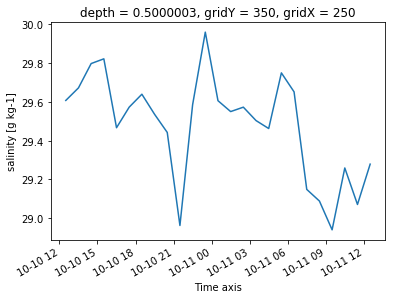

In [7]:
time_series.plot()

### Profile Plots

Now let's look at a 200m deep salinity profile at our `x=250`, `y=350` grid point at a specific time.

The `y` keyword to the `plot` method lets us put depth on the y-axis the way it should be for a profile,
and `yincrease=False` flips the `y` values so that the surface is at the top.

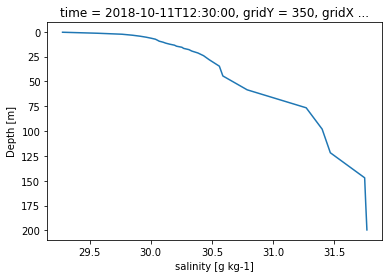

In [8]:
profile = salinity_250_350.sel(time='2018-10-11 12:30', depth=slice(0.5, 200))
profile.plot(y='depth', yincrease=False)

### Filled Contour Plots

So far,
we have used the `sel` method to select results on particular coordinates by individual values
(`time='2018-10-11 12:30'`) or using Python `slice` objects (`depth=slice(0.5, 200)`).
You can also use the `isel` method to select result by index number.

Here we grab salinity at a specific time for a square sub-region of the domain on the 3rd grid layer
(recalling that Python uses 0-based indexing,
so the 3rd grid layer has index number 2):

In [9]:
x_slice, y_slice = slice(250, 350), slice(350, 450)
salinity_5 = ds.salinity.sel(time='2018-10-11 12:30', gridX=x_slice, gridY=y_slice).isel(depth=2)

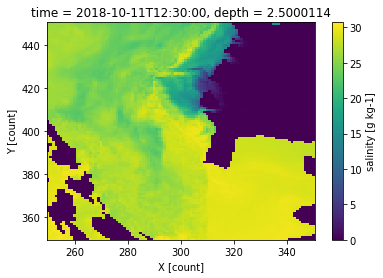

In [10]:
salinity_5.plot()

Switching the colour map to `cmocean.cm.haline`:

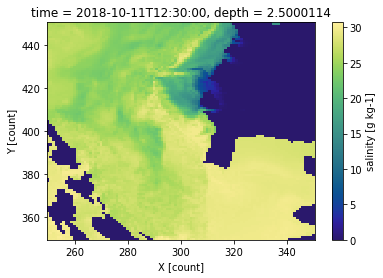

In [11]:
salinity_5.plot(cmap=cmocean.cm.haline)

In [ ]:
type(ds.salinity)

In [ ]:
type(ds.salinity.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).values)

In [ ]:
ds.salinity.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).values)

In [ ]:
ds.salinity.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).plot(cmap=cmocean.cm.haline)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ds.salinity.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).plot(ax=ax1, cmap=cmocean.cm.haline)
ds.temperature.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).plot(ax=ax2, cmap=cmocean.cm.thermal)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ax1.pcolormesh(
    ds.salinity.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0),
    cmap=cmocean.cm.haline
)
ds.temperature.sel(time='2018-10-11 12:30', gridY=slice(350, 450), gridX=slice(250, 350)).isel(depth=0).plot(ax=ax2, cmap=cmocean.cm.thermal)

In [ ]:
bio = xr.open_dataset('/results/SalishSea/nowcast-green/11oct18/SalishSea_1d_20181011_20181011_ptrc_T.nc')
bio